In [7]:
from data_loader import *
from evaluate_captions import *
import csv
from build_vocab import *
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
from model import *

In [4]:
train_json = './data/annotations/captions_train2014.json'
test_json = './data/annotations/captions_val2014.json'
train_root = './data/images/train/'
test_root = './data/images/test/'
vocab = build_vocab(train_json)
with open('TrainImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    trainIds = list(reader)
trainIds = [int(i) for i in trainIds[0]]
#train_dataset = CocoDataset(train_root, train_json, trainIds, vocab)

valIds = trainIds[-len(trainIds)//5:]
trainIds = trainIds[:-len(trainIds)//5]

with open('TestImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)
testIds = [int(i) for i in testIds[0]]
#test_dataset = CocoDataset(test_root, test_json, testIds, vocab)

loading annotations into memory...
Done (t=0.80s)
creating index...


  0%|          | 778/414113 [00:00<00:53, 7774.87it/s]

index created!


100%|██████████| 414113/414113 [00:46<00:00, 8943.12it/s] 


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

tsfm = transforms.Compose([
        transforms.Resize(size=(300,300)),
        transforms.ToTensor(),
        normalize,
    ])
train_loader = get_loader(train_root, train_json, trainIds, vocab, 
                          transform=tsfm, 
                          batch_size=10, 
                          shuffle=True, 
                          num_workers=4)
val_loader = get_loader(train_root, train_json, valIds, vocab, 
                          transform=tsfm, 
                          batch_size=10, 
                          shuffle=True, 
                          num_workers=4)
test_loader = get_loader(test_root, test_json, testIds, vocab, 
                          transform=tsfm, 
                          batch_size=10, 
                          shuffle=True, 
                          num_workers=4)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [49]:
embed_dim = 256
vocab_size= vocab.idx
hiddem_dim = 512
baseline = Img_Caption(encoder= res50_encoder(embed_dim), rnn=nn.RNN, 
                             vocab_size=vocab_size, 
                             embed_dim=embed_dim,
                             hidden_dim=hiddem_dim)

optimizer = optim.Adam(baseline.parameters(), lr=1e-5,weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [50]:

use_gpu = torch.cuda.is_available()
if use_gpu:
    baseline = baseline.cuda()


def train(mod, epochs):
    
    best_loss = float('inf')
    for epoch in range(epochs):
        ts = time.time()
        for i, (imgs, caps, lengths) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                imgs = imgs.cuda()# Move your inputs onto the gpu
                caps = caps.cuda()# Move your labels onto the gpu
                #lengths = lengths.cuda()
            
            outputs = mod(imgs, caps, lengths)
            targets = nn.utils.rnn.pack_padded_sequence(caps, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        # torch.save(fcn_model, 'best_model')
        
        """
        epoch_loss = val(epoch)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(mod, 'best_model')
        mod.train()
        """

In [51]:
epochs  = 10
train(baseline, epochs)

epoch0, iter<built-in function iter>, loss: 10.15722370147705
epoch0, iter<built-in function iter>, loss: 9.713648796081543
epoch0, iter<built-in function iter>, loss: 9.096663475036621
epoch0, iter<built-in function iter>, loss: 7.780392646789551
epoch0, iter<built-in function iter>, loss: 6.380566120147705
epoch0, iter<built-in function iter>, loss: 5.884139537811279
epoch0, iter<built-in function iter>, loss: 5.413450717926025
epoch0, iter<built-in function iter>, loss: 5.475185394287109
epoch0, iter<built-in function iter>, loss: 5.073678493499756
epoch0, iter<built-in function iter>, loss: 4.916116237640381
epoch0, iter<built-in function iter>, loss: 5.064622402191162
epoch0, iter<built-in function iter>, loss: 4.570139408111572
epoch0, iter<built-in function iter>, loss: 4.83132791519165
epoch0, iter<built-in function iter>, loss: 4.337891578674316
epoch0, iter<built-in function iter>, loss: 5.068171501159668
epoch0, iter<built-in function iter>, loss: 4.629211902618408
epoch0, i

KeyboardInterrupt: 

In [44]:
def test(mod):
    mod.eval()
    for i, (imgs, caps, lengths) in enumerate(test_loader):
    
        if use_gpu:
            imgs = imgs.cuda()# Move your inputs onto the gpu
            caps = caps.cuda()# Move your labels onto the gpu
            #lengths = lengths.cuda()
            
        feature = mod.encoder(imgs)
        sampled_ids = mod.sample(feature,max_length = 20)
        
        sampled_ids = sampled_ids[0].cpu().numpy()
        
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
                
        sentence = ' '.join(sampled_caption)
        print (sentence)
        
        sampled_caption = []
        for word_id in caps[0].cpu().numpy():
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption)
        print(sentence)
        plt.imshow(np.asarray(imgs[0].cpu().permute(1,2,0)))
        break
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a man is sitting on a table with a large white plate . <end>
<start> a man standing next to a woman as they stand near bikes . <end>


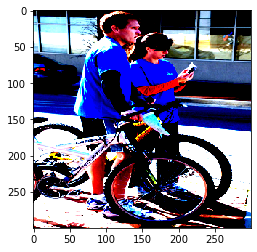

In [45]:
import matplotlib.pyplot as plt
test(baseline)